### 继MATLAB之后，对生成的数据进行处理

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
print(lb.__version__)

0.10.2.post1


In [43]:
'''读取数据'''
import os
path = './audios'
direct_path = os.path.join(path, 'costas_cw_pulse_direct.wav')
shad_1st_path, convg_1st_path = os.path.join(path, 'costas_cw_pulse_1st_shadow.wav'), os.path.join(path, 'costas_cw_pulse_1st_convergence.wav')
shad_2nd_path, convg_2nd_path  = os.path.join(path, 'costas_cw_pulse_2nd_shadow.wav'), os.path.join(path, 'costas_cw_pulse_2nd_convergence.wav')
shad_3rd_path, convg_3rd_path = os.path.join(path, 'costas_cw_pulse_3rd_shadow.wav'), os.path.join(path, 'costas_cw_pulse_3rd_convergence.wav')

shad_1st_echo ,sr= lb.load(shad_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_echo ,sr= lb.load(convg_1st_path,sr=None, mono=True, offset=0.0, duration=None)
convg_1st_echo,shad_1st_echo = np.array(convg_1st_echo), np.array(shad_1st_echo)

shad_2nd_echo ,sr= lb.load(shad_2nd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_2nd_echo ,sr= lb.load(convg_2nd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_2nd_echo,shad_2nd_echo = np.array(convg_2nd_echo), np.array(shad_2nd_echo)

shad_3rd_echo ,sr= lb.load(shad_3rd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_3rd_echo ,sr= lb.load(convg_3rd_path,sr=None, mono=True, offset=0.0, duration=None)
convg_3rd_echo,shad_3rd_echo = np.array(convg_3rd_echo), np.array(shad_3rd_echo)


In [ ]:
print(type(convg_1st_echo))
#sig = lb.resample(y=convg_1st_echo, orig_sr=sr, target_sr=200) 


<class 'numpy.ndarray'>


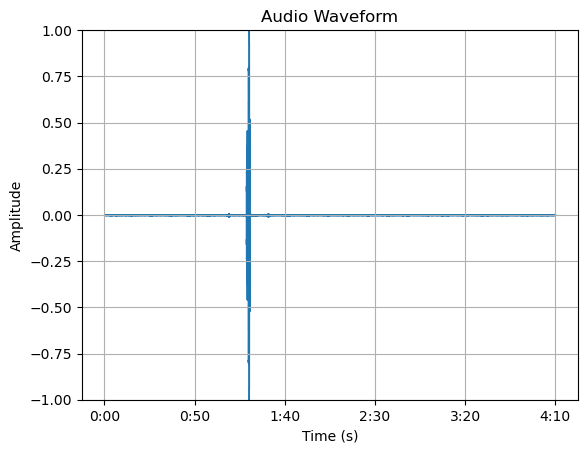

In [58]:
sr = lb.get_samplerate(os.path.join(path, 'costas_cw_pulse_1st_shadow.wav'))
# 手动生成时间轴
# time = np.arange(0, len(sig)) / sr  # 时间轴，单位为秒
# # 增加 agg.path.chunksize
# plt.rcParams['agg.path.chunksize'] = 10000  # 设置为 10000 或更大的值
# # 增加路径简化阈值
# plt.rcParams['path.simplify_threshold'] = 0.5  # 默认值是 0.111111，增大到 0.5 或更高
lb.display.waveshow(convg_1st_echo, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

In [96]:
frame_length ,hop_length =2048, 512
# 分帧操作
# 对音频数据进行填充（必要步骤，可确保分帧完整）
padded_y = np.pad(convg_1st_echo, (frame_length // 2, frame_length // 2), mode='reflect')
#进行分帧
frames = lb.util.frame(padded_y, frame_length=frame_length, hop_length=hop_length)
# 计算每帧的能量
frame_energies = np.sum(np.abs(frames) ** 2, axis=0)
#读取过零率
zcrs = lb.feature.zero_crossing_rate(padded_y, frame_length = frame_length, hop_length = hop_length, center = True) 

In [99]:
#frames的每一列为一帧
print(f"帧数：{len(frames[0])}")
print(f"第一帧过零率：{zcrs[0,1]}")
max_zcr = max(zcrs[0])
max_energy = max(frame_energies)
vad_idx1,vad_idx2 = [],[]
for i,energy in enumerate(frame_energies):
    if energy >= 0.4*max_energy:
        vad_idx1.append(i)
for i,zcr in enumerate(zcrs[0]):
    if zcr >= 0.4*max_zcr:
        vad_idx2.append(i)
print(vad_idx1)
pulse_start = vad_idx1[0]*(hop_length-1)*frame_length/sr
pulse_end = vad_idx1[-1]*(hop_length-1)*frame_length/sr
print(f"脉冲起始位置：{pulse_start}s，脉冲终止位置：{pulse_end}s")

extracted_frames = [frames[:,i] for i in range(vad_idx1[0],vad_idx1[-1]+1)]

帧数：1954
第一帧过零率：0.564453125
[620, 621, 622, 623, 624, 625, 626, 627]
脉冲起始位置：162211.84s，脉冲终止位置：164043.264s


In [104]:
print(type(extracted_frames))
extracted_frames = np.array(extracted_frames)
print(type(extracted_frames))

<class 'list'>
<class 'numpy.ndarray'>


In [111]:
reconstructed_signal = lb.util.fix_length(y=extracted_frames.flatten(), length=(vad_idx1[-1] - vad_idx1[0] + 1) * hop_length)
# 去除填充部分
start_index = frame_length // 2 + vad_idx1[0] * hop_length
end_index = start_index + (vad_idx1[-1] - vad_idx1[0] + 1) * hop_length - frame_length
final_signal = reconstructed_signal[start_index:end_index]

TypeError: fix_length() missing 1 required positional argument: 'data'